# Geração de imagens com GANs

- Código adaptado da documentação: https://www.tensorflow.org/beta/tutorials/generative/dcgan




**Importação das bibliotecas**

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

**Importação e tratamento da base de dados**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
train_labels.shape

(60000,)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
# Normalização entre -1 e 1 (para as GANS os estudos mostram que essa normalizacao seria melhor)
train_images = (train_images - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [ ]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

**Visualização dos dados**

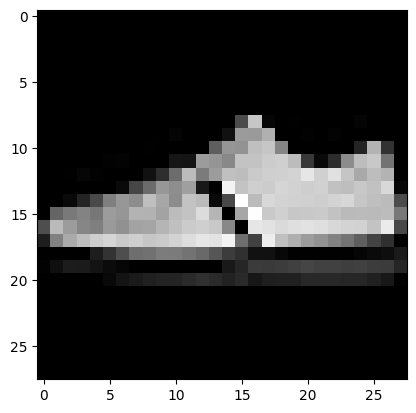

In [ ]:
plt.imshow(train_images[132].reshape((28,28)) , cmap = 'gray')

**Construção do gerador**

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  #7x7x128
  model.add(layers.Conv2DTranspose(128, (5,5), strides = (1, 1), padding = 'same',
                                   use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #14x14x64
  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2, 2), padding = 'same',
                                   use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #28x28x1
  model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', 
                                   use_bias = False, activation = 'tanh'))
  model.summary()

  return model


In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1908580e-02,  1.1581175e+00, -1.5827640e+00, -1.3390397e+00,
         8.9463377e-01, -1.9741468e+00, -1.9442538e+00, -8.5229892e-01,
         1.3075055e+00, -1.4400367e+00,  7.3418170e-01,  7.3066187e-01,
         6.0353673e-01, -6.1347485e-01, -1.3176692e+00,  9.9348998e-01,
        -2.0582802e-04, -6.3461214e-01,  4.9675125e-01,  1.6669142e-01,
         9.0781611e-01, -1.7733892e+00,  2.5052410e-01, -1.5239023e-01,
         3.4637108e-01,  8.4407657e-01,  1.2184392e+00,  1.8105176e-01,
        -5.5135995e-02,  4.8236349e-01, -1.4719589e+00,  1.3853667e+00,
        -6.4315379e-01,  5.8665019e-01, -1.6214502e+00, -2.9290441e-01,
         5.2062881e-01, -3.8975742e-01, -3.9690807e-01, -4.5957735e-01,
        -2.3905365e-01,  3.5995716e-01, -3.8840324e-01, -1.5954934e-02,
        -7.5835466e-01, -2.6227215e-01,  5.2524400e-01,  4.4810200e-01,
         5.9830701e-01,  2.3177120e-01, -8.4181798e-01,  3.2916823e-01,
         1.420

In [ ]:
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
generated_image = generator(noise, training = False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

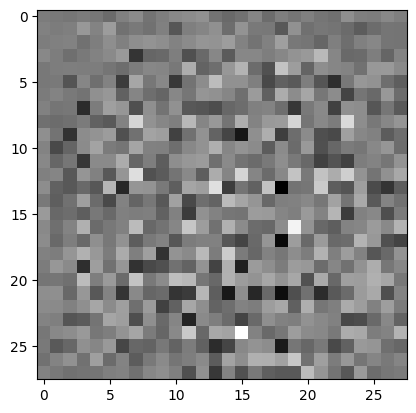

In [ ]:
plt.imshow(generated_image[0,:,:,0], cmap='gray')

**Construção do discriminador**

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()

  #14x14x64
  model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', 
                                                         input_shape = (28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #7x7x128
  model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  #6272
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  model.summary()
  
  return model

In [ ]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00304031]], dtype=float32)>

**Loss function para as duas redes**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # 0.00001

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**Treinamento do modelo**

In [ ]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
batch_size

256

In [ ]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #Chamar o gerador e passar os numeros aleatorios
    generated_images = generator(noise, training = True)

    #Passar para o discriminador as imagens reais e falsas para fazer a classificacao
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    #Calcular a loss para o gerador e discriminador
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  #CAlcular o gradiente das losses para atualizar os pesos
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #Aplicar os otimizadores e atualizar os pesos
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch + 1, seed) 

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

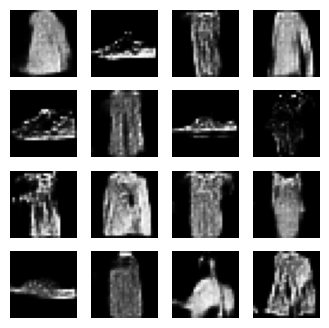

In [ ]:
train(train_dataset, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

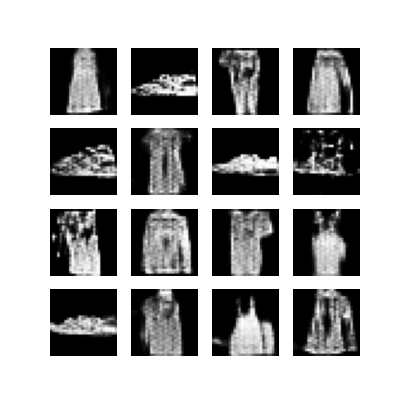

In [ ]:
display_image(80)